Epoch 1, Train Loss: 0.1840, Val Loss: 0.1817
Epoch 2, Train Loss: 0.1790, Val Loss: 0.1807
Epoch 3, Train Loss: 0.1779, Val Loss: 0.1799
Epoch 4, Train Loss: 0.1774, Val Loss: 0.1795
Epoch 5, Train Loss: 0.1768, Val Loss: 0.1801
Epoch 6, Train Loss: 0.1763, Val Loss: 0.1790
Epoch 7, Train Loss: 0.1758, Val Loss: 0.1783
Epoch 8, Train Loss: 0.1754, Val Loss: 0.1778
Epoch 9, Train Loss: 0.1749, Val Loss: 0.1777
Epoch 10, Train Loss: 0.1743, Val Loss: 0.1769
Epoch 11, Train Loss: 0.1736, Val Loss: 0.1764
Epoch 12, Train Loss: 0.1732, Val Loss: 0.1764
Epoch 13, Train Loss: 0.1726, Val Loss: 0.1763
Epoch 14, Train Loss: 0.1721, Val Loss: 0.1756
Epoch 15, Train Loss: 0.1716, Val Loss: 0.1747
Epoch 16, Train Loss: 0.1712, Val Loss: 0.1746
Epoch 17, Train Loss: 0.1708, Val Loss: 0.1744
Epoch 18, Train Loss: 0.1705, Val Loss: 0.1739
Epoch 19, Train Loss: 0.1701, Val Loss: 0.1738
Epoch 20, Train Loss: 0.1698, Val Loss: 0.1742
Epoch 21, Train Loss: 0.1694, Val Loss: 0.1738
Epoch 22, Train Loss: 

/var/folders/bg/rj2597hd4399k2ht0hpblk9r0000gn/T/ipykernel_77889/3456345704.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_gru_

Test MAE: 0.3961, Test RMSE: 0.6807


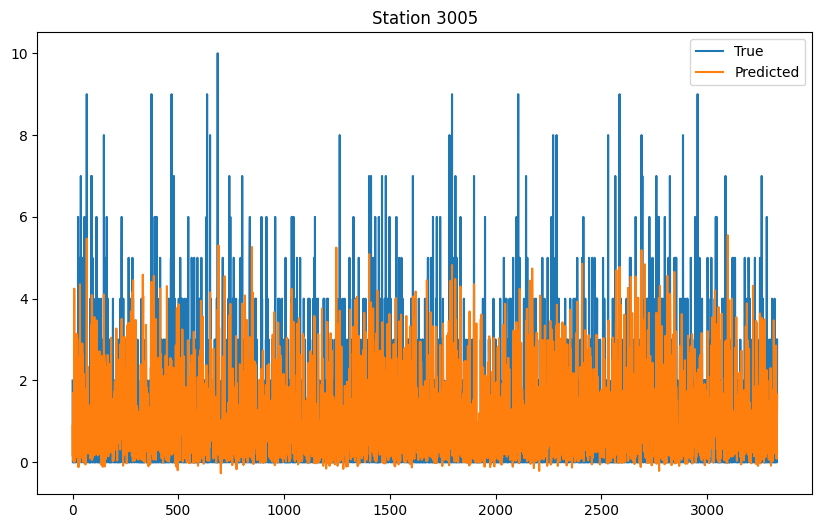

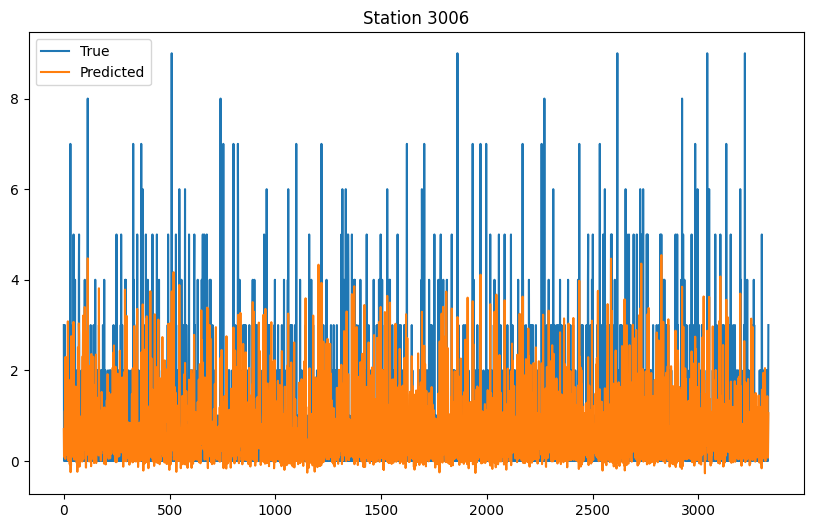

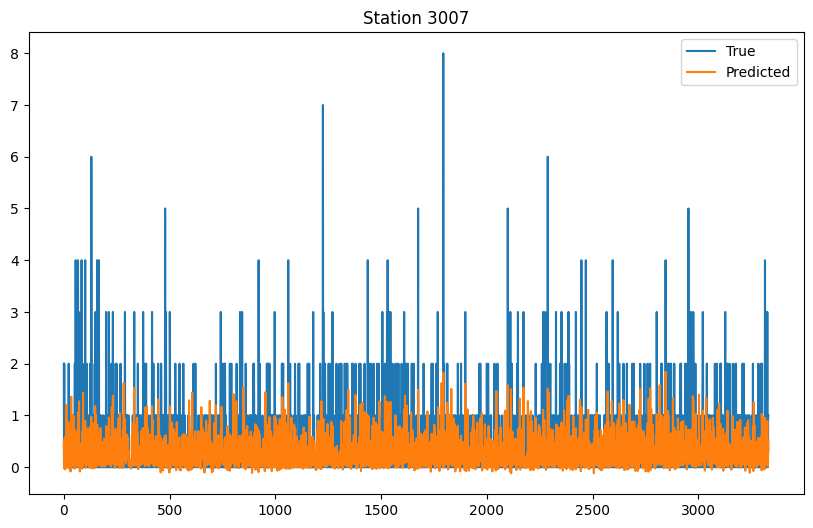

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv('pivot_50_peak.csv')

# 数据预处理
# 提取特征列和目标列
numerical_features = ['temperature_2m (°C)', 'apparent_temperature (°C)', 'rain (mm)', 'wind_speed_100m (km/h)']
categorical_features = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos','peak_stage_off_peak','peak_stage_other','peak_stage_peak']
stations = [col for col in data.columns if col.isdigit()] 
# 构造输入X和目标y
X = data[categorical_features + numerical_features].values
y = data[stations].values
# 定义时间窗口
time_window = 24

# 构造时间窗口的数据集
def create_time_window(X, y, time_window):
    X_window, y_window = [], []
    for i in range(len(X) - time_window):
        X_window.append(X[i:i+time_window])
        y_window.append(y[i+time_window])  # 预测当前时间步的目标
    return np.array(X_window), np.array(y_window)

X_window, y_window = create_time_window(X, y, time_window)

# 划分训练集、验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(X_window, y_window, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 转换为Tensor
X_train, X_val, X_test = map(torch.tensor, (X_train, X_val, X_test))
y_train, y_val, y_test = map(torch.tensor, (y_train, y_val, y_test))

# 数据集类
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 数据加载器
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

from torch.nn import HuberLoss  # 导入 Huber Loss

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # 只取最后一个时间步的输出
        return out

# 模型初始化
input_dim = X_train.shape[2]
hidden_dim = 64
output_dim = y_train.shape[1]
num_layers = 2
dropout = 0.3
model = GRUModel(input_dim, hidden_dim, output_dim, num_layers, dropout)

# 使用 Huber Loss 替代 MSELoss，并设置 delta 参数
delta = 1.0  # 可以根据数据分布或验证集表现调整该值
criterion = HuberLoss(delta=delta)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_val_loss = float('inf')
patience = 5
trigger_times = 0

for epoch in range(100):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.float().to(device), y_batch.float().to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)  # 使用 Huber Loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.float().to(device), y_batch.float().to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)  # 使用 Huber Loss
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # 早停机制
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_gru_model.pth')  # 保存最佳模型
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break

# 加载最佳模型
model.load_state_dict(torch.load('best_gru_model.pth'))

# 测试模型
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.float().to(device)
        outputs = model(X_batch)
        y_pred.append(outputs.cpu().numpy())
        y_true.append(y_batch.numpy())

y_pred = np.vstack(y_pred)
y_true = np.vstack(y_true)

# 评估指标
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Test MAE: {mae:.4f}, Test RMSE: {rmse:.4f}")

# 可视化3个车站的预测结果
stations_to_plot = stations[:3]  # 选择前3个车站
for station in stations_to_plot:
    station_idx = stations.index(station)
    plt.figure(figsize=(10, 6))
    plt.plot(y_true[:, station_idx], label="True")
    plt.plot(y_pred[:, station_idx], label="Predicted")
    plt.title(f"Station {station}")
    plt.legend()
    plt.show()
